In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from Training import model, utils, dataset, train
import numpy as np
from sklearn import preprocessing
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d

In [2]:
test_model_1 = model.Model500RELUBN(output_count = 4)
# load data 1066 data 
data1 = utils.parseGainAndBWCsv2('Data/BW-3000.csv')


data = np.array(data1).astype(float)
#data = np.array(data1).astype(float)

In [3]:
print(data.shape)


(3022, 4)


In [4]:
data = data.reshape(data.shape[0],4)
feature = data.T[0]

### OLD NORM CODE ###
# #ensure norm and denorm work 
# norm, data_min, data_max = utils.normalize(feature)
# feature_1 = utils.denormalize(norm, data_min, data_max)


# min_max = dict()
# for i in range(4):
#     feature = data.T[i]
#     norm_feature, data_min, data_max = utils.normalize(feature)
#     data.T[i] = norm_feature
#     min_max[i] = [data_min, data_max]
# norm_data, min_max = utils.normalize(data)
# denorm__data = utils.denormalize(norm_data, min_max)
### END OLD NORM CODE ###

norm_data, min_max = utils.normalize(data)
denorm_data = utils.denormalize(norm_data, min_max)
data = norm_data.reshape(norm_data.shape[0],2,2)

#data = data.reshape(data.shape[0],2,2)

In [5]:
data_x = data[:, 1]
data_y = data[: ,0]
data_set = dataset.CircuitSynthesisGainAndBandwidthManually(data_x, data_y)

In [6]:
train_dataset, val_dataset = utils.splitDataset(data_set, 0.8)

In [7]:
dtype = torch.FloatTensor
loss_fn = nn.GaussianNLLLoss().type(dtype)  # loss can be changed here. This is the first one i tried that gave meaningful results

x = optim.Adam
optimizer1 = x(test_model_1.parameters(), lr=3e-4)#0.06448295999961791)  # TODO haven't experimented with this yet
train_data = DataLoader(train_dataset, batch_size=250)
test_data = DataLoader(val_dataset, batch_size = 50)

In [8]:
total_train = len(train_dataset)
total_test = len(val_dataset)

In [9]:
def normalize(data):
    assert data.shape[1] == 4, "reshape the data first to (-1, 4)"
    normed_data = np.zeros(data.shape)
    normers = []
    for i in range(len(data.T)):
        normer = preprocessing.MinMaxScaler((-1,1))
        normed_data.T[i] = normer.fit_transform(data.T[i].reshape(-1,1)).reshape(-1)
        normers.append(normer)
    return normed_data,np.array(normers)

def denormalize(normed_data,normers):
    denormed_data = np.zeros(normed_data.shape)
    for i in range(len(normed_data.T)):
        denormed_data.T[i] = normers[i].inverse_transform(normed_data.T[i].reshape(-1,1)).reshape(-1)
    return denormed_data

In [10]:
def a(model, loader, min_max, margin, dtype=torch.FloatTensor, verbose = True):
    num_part_correct = 0
    num_part_samples = 0
    num_correct = 0
    num_samples = 0
    
    model.eval()  # Put the model in test mode (the opposite of model.train(), essentially)
    loss_list = []
    all_preds = []
    for x, y in loader:
        with torch.no_grad():
            x_var = torch.autograd.Variable(x.type(dtype))

        y_hat = model(x_var)
        
        y_hat = np.array(y_hat.detach())
        var1_expectation = y_hat[:,0]
        var2_expectation = y_hat[:,1]
        var1_std = np.sqrt(np.absolute(y_hat[:,2]))
        var2_std = np.sqrt(np.absolute(y_hat[:,3]))
        
        var1 = np.random.normal(var1_expectation, var1_std)[:,None]
        var2 = np.random.normal(var2_expectation, var2_std)[:,None]
        y_hat = np.concatenate((var1,var2), axis = 1)

        y_min_max = min_max[2:] # discard x min_maxs
        y = denormalize(y,y_min_max)
        y_hat = denormalize(y_hat,y_min_max)
       
        err = np.abs(y_hat - y)/y
        for row in err:
            num_in_row = len(np.where(row < margin)[0])
            if num_in_row == len(row):
                num_correct += 1

        num_samples += y.shape[0]
        correct_idx = np.where(err < margin)
        num_part_correct += len(correct_idx[0])
        num_part_samples += y.shape[0] * y.shape[1]
        
        all_preds.extend(y_hat)
    part_acc = float(num_part_correct) / num_part_samples
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d partially correct (%.2f pct)' % (num_part_correct, num_part_samples, 100 * part_acc)) 
        print('Got %d / %d correct (%.2f pct)' % (num_correct, num_samples, 100 * acc)) 
    return acc, part_acc, all_preds



In [11]:
ta5 = []
ta10 = []
ta20 = []
va5 = []
va10 = []
va20 = []
train_loss = []
for epoch in range(500):

    avg_loss = 0
        
    test_model_1.train()
    for t, (x, y) in enumerate(train_data):

        x_var = torch.autograd.Variable(x.type(dtype))
        y_var = torch.autograd.Variable(y.type(dtype).float())

        # make predictions
        output = test_model_1(x_var)
        
        expectation_1 = output[:,0]
        expectation_2 = output[:,1]
        var_1 = torch.exp(2 * output[:,2])
        var_2 = torch.exp(2 * output[:,3])
        loss1 = loss_fn(expectation_1, y_var[:,0], var_1)
        loss2 = loss_fn(expectation_2, y_var[:,1], var_2)
        avg_loss += (loss1.item() + loss2.item() - avg_loss) / (t+1)
        loss = loss1 + loss2
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
    
    print('t = %d, loss = %.4f' % (epoch + 1, avg_loss))
    train_loss.append(avg_loss)
    vacc5, _,_ = a(test_model_1, test_data, min_max, .05, verbose=False)
    vacc10, _,_ = a(test_model_1, test_data, min_max, .1, verbose=False)
    vacc20, _,_ = a(test_model_1, test_data, min_max, .2, verbose=False)
    tacc5, _,_ = a(test_model_1, train_data, min_max, .05, verbose=False)
    tacc10, _,_ = a(test_model_1, train_data, min_max, .1, verbose=False)
    tacc20, _,_ = a(test_model_1, train_data, min_max, .2, verbose=False)
    
    ta5.append(tacc5)
    ta10.append(tacc10)
    ta20.append(tacc20)
    va5.append(vacc5)
    va10.append(vacc10)
    va20.append(vacc20)


t = 1, loss = -0.1347
t = 2, loss = -0.7116
t = 3, loss = -0.9774
t = 4, loss = -1.1482
t = 5, loss = -1.3516
t = 6, loss = -1.5087
t = 7, loss = -1.5875
t = 8, loss = -1.6752
t = 9, loss = -1.7687
t = 10, loss = -1.9559
t = 11, loss = -1.9397
t = 12, loss = -1.9513
t = 13, loss = -2.0290
t = 14, loss = -2.0902
t = 15, loss = -2.1531
t = 16, loss = -2.0343
t = 17, loss = -2.1174
t = 18, loss = -2.0920
t = 19, loss = -2.1117
t = 20, loss = -1.9855
t = 21, loss = -2.1471
t = 22, loss = -2.3115
t = 23, loss = -2.5051
t = 24, loss = -2.4143
t = 25, loss = -2.1635
t = 26, loss = -2.1059
t = 27, loss = -2.2080
t = 28, loss = -2.4412
t = 29, loss = -2.6815
t = 30, loss = -2.8636
t = 31, loss = -2.8162
t = 32, loss = -2.5297
t = 33, loss = -2.5792
t = 34, loss = -2.4652
t = 35, loss = -2.5274
t = 36, loss = -2.5636
t = 37, loss = -2.6133
t = 38, loss = -2.6768
t = 39, loss = -2.6875
t = 40, loss = -2.6832
t = 41, loss = -2.6195
t = 42, loss = -2.7558
t = 43, loss = -2.8152
t = 44, loss = -2.87

t = 347, loss = -3.9353
t = 348, loss = -3.9750
t = 349, loss = -3.9413
t = 350, loss = -4.1453
t = 351, loss = -4.3207
t = 352, loss = -4.2472
t = 353, loss = -4.1980
t = 354, loss = -4.2463
t = 355, loss = -4.1773
t = 356, loss = -4.1387
t = 357, loss = -3.9504
t = 358, loss = -3.9253
t = 359, loss = -3.8793
t = 360, loss = -3.9254
t = 361, loss = -3.9314
t = 362, loss = -4.1157
t = 363, loss = -4.2237
t = 364, loss = -4.3468
t = 365, loss = -4.3738
t = 366, loss = -4.3198
t = 367, loss = -4.3051
t = 368, loss = -3.9951
t = 369, loss = -3.7890
t = 370, loss = -3.7945
t = 371, loss = -3.8375
t = 372, loss = -4.0014
t = 373, loss = -4.2061
t = 374, loss = -4.3770
t = 375, loss = -4.4765
t = 376, loss = -4.3149
t = 377, loss = -4.0975
t = 378, loss = -3.8198
t = 379, loss = -3.6790
t = 380, loss = -3.8391
t = 381, loss = -4.0081
t = 382, loss = -4.2398
t = 383, loss = -4.3421
t = 384, loss = -4.2945
t = 385, loss = -4.2770
t = 386, loss = -4.1007
t = 387, loss = -3.8986
t = 388, loss = 

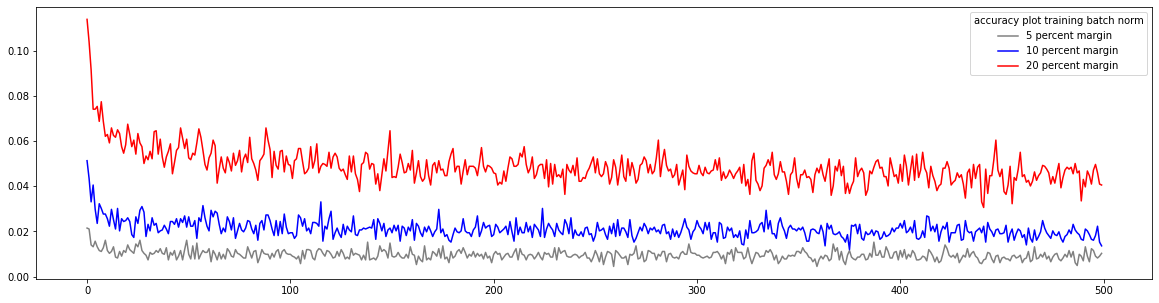

In [12]:
plt.figure(figsize = (20,5))
plt.plot(ta5, color='grey', label='5 percent margin')
plt.plot(ta10, color='blue', label = '10 percent margin')
plt.plot(ta20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot training batch norm')
plt.show()

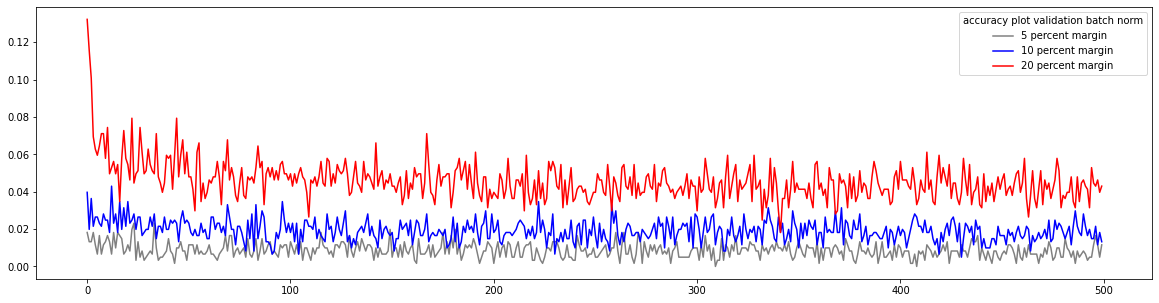

In [13]:
plt.figure(figsize=(20,5))
plt.plot(va5, color='grey', label='5 percent margin')
plt.plot(va10, color='blue', label = '10 percent margin')
plt.plot(va20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot validation batch norm')
plt.show()

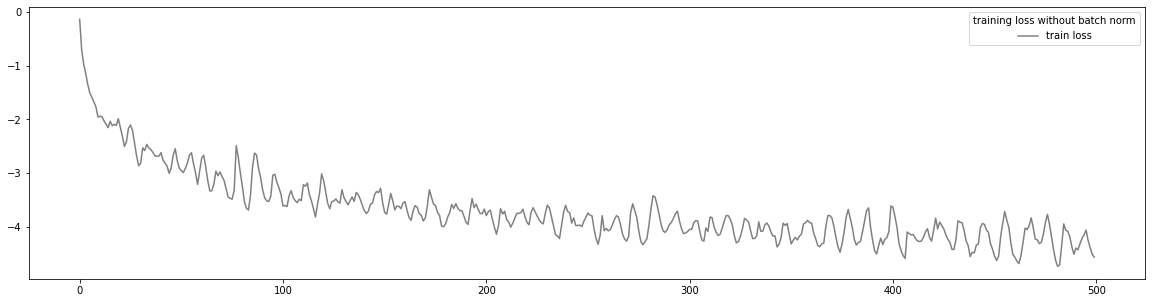

In [14]:
plt.figure(figsize=(20,5))
plt.plot(train_loss, color='grey', label='train loss')
plt.legend(title = 'training loss without batch norm')
plt.show()

In [15]:
max(va5)

0.023140495867768594

In [16]:
max(ta5)

0.0215142738932561

In [17]:
min_max

array([MinMaxScaler(copy=True, feature_range=(-1, 1)),
       MinMaxScaler(copy=True, feature_range=(-1, 1)),
       MinMaxScaler(copy=True, feature_range=(-1, 1)),
       MinMaxScaler(copy=True, feature_range=(-1, 1))], dtype=object)

In [18]:
min_max.shape

(4,)

In [19]:
# Each data point will be a tuple with a format of (Transistor width, resistor load, Bandwidth, Gain)
k = data_set[2]


In [20]:
x,y=k[0],k[1]

In [21]:
y = torch.tensor(y[None,:]).float()

In [22]:

y_hat = test_model_1(y)

In [23]:
x

array([0.16404494, 0.17159763])

In [24]:
y

tensor([[-1.0000, -0.7973]])

In [25]:
y_n = utils.denormalize(y,min_max[2:,:])

IndexError: too many indices for array

In [ ]:
x_n = utils.denormalize(x[None,:],min_max[0:2,:])

In [ ]:
p = utils.denormalize(y_hat.detach().numpy(),min_max[2:,:])

In [ ]:
def test_simulator(width, resistor):
    gain = 20 * math.log(abs(-1 * resistor * (49 * math.pow(10, -3) * 0.02302 * width / math.pow(10, -6) * 0.2)),10)
    bandwidth = 1/(2 * math.pi * resistor * 348.435)
    return gain, bandwidth

In [ ]:
test_simulator(x_n[0,0], x_n[0,1])

In [ ]:
y_n